In [1]:
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score

from scipy.sparse import csr_matrix

plt.style.use('default')
sns.set_style("whitegrid")


# User-Based Collaborative Filtering News Recommendation System

## 1. Dataset Loading


In [2]:
# Load dataset
notebook_dir = Path(os.getcwd())
data_root = notebook_dir / 'MINDsmall_train'

news = pd.read_csv(
    data_root / 'news.tsv',
    sep='\t',
    header=None,
    names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'],
    on_bad_lines='skip'
)

behaviors = pd.read_csv(
    data_root / 'behaviors.tsv',
    sep='\t',
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'],
    on_bad_lines='skip'
)

print(f"Dataset: {len(news):,} articles, {len(behaviors):,} impressions, {behaviors['user_id'].nunique():,} users")


Dataset: 51,282 articles, 156,965 impressions, 50,000 users


In [3]:
# Dataset statistics
print(f"Articles: {len(news):,}, Categories: {news['category'].nunique()}")
print(f"Impressions: {len(behaviors):,}, Users: {behaviors['user_id'].nunique():,}")
print(f"Missing abstracts: {news['abstract'].isna().sum()}")


Articles: 51,282, Categories: 17
Impressions: 156,965, Users: 50,000
Missing abstracts: 2666


## 2. Data Preprocessing


In [4]:
def parse_impressions(impression_str):
    """Parse impression string format: 'N123-1 N456-0' -> (items, labels)"""
    if pd.isna(impression_str) or impression_str == '':
        return [], []
    items, labels = [], []
    for pair in str(impression_str).split():
        try:
            nid, lbl = pair.split('-')
            items.append(nid)
            labels.append(int(lbl))
        except ValueError:
            continue
    return items, labels

# Parse impressions
behaviors['imp_items'], behaviors['imp_labels'] = zip(
    *behaviors['impressions'].apply(parse_impressions)
)

# Calculate click statistics
total_impressions = behaviors['imp_items'].apply(len).sum()
total_clicks = behaviors['imp_labels'].apply(sum).sum()
click_rate = total_clicks / total_impressions if total_impressions > 0 else 0

print(f"Impressions: {total_impressions:,}, Clicks: {total_clicks:,}, Click rate: {click_rate:.2%}")


Impressions: 5,843,444, Clicks: 236,344, Click rate: 4.04%


## 3. Build User Click Histories


In [5]:
# Build user click history
user_clicked = {}
for _, row in behaviors.iterrows():
    uid = row['user_id']
    clicked = [item for item, label in zip(row['imp_items'], row['imp_labels']) if label == 1]
    if uid not in user_clicked:
        user_clicked[uid] = []
    user_clicked[uid].extend(clicked)

# Remove duplicates
for uid in user_clicked:
    user_clicked[uid] = list(dict.fromkeys(user_clicked[uid]))

click_counts = [len(clicks) for clicks in user_clicked.values()]
print(f"Users: {len(user_clicked):,}, Average clicks per user: {np.mean(click_counts):.2f}, Median: {np.median(click_counts):.1f}")

# Build article popularity for cold-start fallback
article_popularity = {}
for _, row in behaviors.iterrows():
    for item, label in zip(row['imp_items'], row['imp_labels']):
        if label == 1:
            article_popularity[item] = article_popularity.get(item, 0) + 1

if article_popularity:
    max_pop = max(article_popularity.values())
    article_popularity = {k: v / max_pop for k, v in article_popularity.items()}
print(f"Articles with popularity scores: {len(article_popularity):,}")


Users: 50,000, Average clicks per user: 4.69, Median: 3.0
Articles with popularity scores: 7,713


## 4. Build User-Item Matrix


In [6]:
# Create user-item interaction matrix
# Rows: users, Columns: articles, Values: 1 if clicked, 0 otherwise
all_users = sorted(list(user_clicked.keys()))
all_articles = sorted(list(set().union(*[set(clicks) for clicks in user_clicked.values()])))

user_to_idx = {uid: i for i, uid in enumerate(all_users)}
article_to_idx = {aid: i for i, aid in enumerate(all_articles)}

# Build sparse matrix
row_indices = []
col_indices = []
data = []

for uid, clicked_articles in user_clicked.items():
    user_idx = user_to_idx[uid]
    for article_id in clicked_articles:
        if article_id in article_to_idx:
            col_idx = article_to_idx[article_id]
            row_indices.append(user_idx)
            col_indices.append(col_idx)
            data.append(1.0)

user_item_matrix = csr_matrix((data, (row_indices, col_indices)), 
                              shape=(len(all_users), len(all_articles)))

print(f"User-Item matrix shape: {user_item_matrix.shape}")
print(f"Matrix density: {user_item_matrix.nnz / (user_item_matrix.shape[0] * user_item_matrix.shape[1]):.6f}")
print(f"Users: {len(all_users):,}, Articles: {len(all_articles):,}")


User-Item matrix shape: (50000, 7713)
Matrix density: 0.000608
Users: 50,000, Articles: 7,713


## 5. Compute User-User Similarity


In [7]:
# Compute user-user similarity matrix using cosine similarity
# This can be memory intensive, so we'll compute it in chunks or use a sample
# For efficiency, we'll compute similarities on-demand or use a subset

# Compute user-user similarity (cosine similarity on user vectors)
print("Computing user-user similarity matrix...")
user_similarity = cosine_similarity(user_item_matrix)
print(f"User similarity matrix shape: {user_similarity.shape}")

# Store top-k similar users for each user (for efficiency)
top_k_similar = 50  # Number of similar users to consider
user_similar_users = {}

for i, uid in enumerate(all_users):
    # Get similarities for this user (excluding self)
    similarities = user_similarity[i].copy()
    similarities[i] = -1  # Exclude self
    
    # Get top-k similar users
    top_indices = np.argsort(similarities)[::-1][:top_k_similar]
    user_similar_users[uid] = [(all_users[idx], similarities[idx]) 
                                for idx in top_indices if similarities[idx] > 0]

print(f"Computed similar users for {len(user_similar_users):,} users")


Computing user-user similarity matrix...
User similarity matrix shape: (50000, 50000)
Computed similar users for 50,000 users


## 6. Scoring and Ranking


In [8]:
def score_impression(impression_row):
    """Score articles using user-based collaborative filtering."""
    uid = impression_row['user_id']
    items = impression_row['imp_items']
    scores = np.zeros(len(items))
    
    # Get similar users
    if uid not in user_similar_users:
        # Cold-start: use popularity
        for i, news_id in enumerate(items):
            scores[i] = article_popularity.get(news_id, 0.0) * 0.5
        return scores
    
    similar_users = user_similar_users[uid]
    if len(similar_users) == 0:
        # No similar users: use popularity
        for i, news_id in enumerate(items):
            scores[i] = article_popularity.get(news_id, 0.0) * 0.5
        return scores
    
    # Aggregate scores from similar users
    # Weight by similarity and normalize
    for i, news_id in enumerate(items):
        score_sum = 0.0
        similarity_sum = 0.0
        
        for similar_uid, similarity in similar_users:
            if similarity > 0 and similar_uid in user_clicked:
                if news_id in user_clicked[similar_uid]:
                    score_sum += similarity
                similarity_sum += abs(similarity)
        
        if similarity_sum > 0:
            scores[i] = score_sum / similarity_sum
    
    # Add popularity fallback for articles with no similar user clicks
    for i, news_id in enumerate(items):
        pop_score = article_popularity.get(news_id, 0.0)
        if scores[i] == 0:
            scores[i] = pop_score * 0.3
        else:
            scores[i] = scores[i] * 0.9 + pop_score * 0.1
    
    return scores


## 7. Evaluation


In [9]:
def evaluate_recommendations(behaviors_df, sample_size=None, random_seed=42):
    """Evaluate recommendation system using multiple metrics."""
    eval_df = behaviors_df.sample(n=min(sample_size, len(behaviors_df)), random_state=random_seed) if sample_size else behaviors_df.copy()
    
    hits_at_1 = 0
    reciprocal_ranks = []
    ndcg_scores = []
    auc_scores = []
    total_evaluated = 0
    
    for _, row in eval_df.iterrows():
        scores = score_impression(row)
        labels = np.array(row['imp_labels'])
        
        if sum(labels) == 0 or np.all(scores == 0):
            continue
        
        total_evaluated += 1
        
        try:
            auc_scores.append(roc_auc_score(labels, scores))
        except ValueError:
            pass
        
        ranked_indices = np.argsort(scores)[::-1]
        
        if labels[ranked_indices[0]] == 1:
            hits_at_1 += 1
        
        clicked_ranks = [i + 1 for i, idx in enumerate(ranked_indices) if labels[idx] == 1]
        if clicked_ranks:
            reciprocal_ranks.append(1.0 / clicked_ranks[0])
        
        top_5_indices = ranked_indices[:5]
        dcg = sum((labels[idx] / np.log2(i + 2)) for i, idx in enumerate(top_5_indices))
        ideal_ranks = sorted([i + 1 for i, idx in enumerate(ranked_indices) if labels[idx] == 1])[:5]
        idcg = sum(1.0 / np.log2(rank + 1) for rank in ideal_ranks)
        ndcg_scores.append(dcg / idcg if idcg > 0 else 0.0)
    
    return {
        'Hit Rate @ 1': hits_at_1 / total_evaluated if total_evaluated > 0 else 0.0,
        'MRR': np.mean(reciprocal_ranks) if reciprocal_ranks else 0.0,
        'NDCG @ 5': np.mean(ndcg_scores) if ndcg_scores else 0.0,
        'AUC': np.mean(auc_scores) if auc_scores else 0.0,
        'Coverage': total_evaluated / len(eval_df) if len(eval_df) > 0 else 0.0,
        'Total Evaluated': total_evaluated
    }

# Evaluate on training set
train_metrics = evaluate_recommendations(behaviors, sample_size=None, random_seed=42)
print("Training Set Results:")
for metric, value in train_metrics.items():
    if metric == 'Total Evaluated':
        print(f"  {metric}: {value:,}")
    elif metric == 'Coverage':
        print(f"  {metric}: {value:.2%}")
    else:
        print(f"  {metric}: {value:.4f}")


Training Set Results:
  Hit Rate @ 1: 0.6080
  MRR: 0.7032
  NDCG @ 5: 0.7752
  AUC: 0.8352
  Coverage: 100.00%
  Total Evaluated: 156,965


In [10]:
def recommend_for_user(user_id, top_k=5, exclude_clicked=True):
    """Generate top-k recommendations for a user based on similar users."""
    if user_id not in user_similar_users:
        # Cold-start: return popular articles
        popular_articles = sorted(article_popularity.items(), key=lambda x: x[1], reverse=True)[:top_k]
        recommendations = []
        for news_id, score in popular_articles:
            article_info = news[news['news_id'] == news_id]
            if len(article_info) > 0:
                recommendations.append({
                    'news_id': news_id,
                    'title': article_info.iloc[0]['title'],
                    'category': article_info.iloc[0]['category'],
                    'similarity_score': score
                })
        return pd.DataFrame(recommendations)
    
    similar_users = user_similar_users[user_id]
    if len(similar_users) == 0:
        return pd.DataFrame({'news_id': [], 'title': [], 'category': []})
    
    # Aggregate articles from similar users
    article_scores = {}
    clicked = set(user_clicked.get(user_id, []))
    
    for similar_uid, similarity in similar_users:
        if similarity > 0 and similar_uid in user_clicked:
            for article_id in user_clicked[similar_uid]:
                if exclude_clicked and article_id in clicked:
                    continue
                if article_id not in article_scores:
                    article_scores[article_id] = 0.0
                article_scores[article_id] += similarity
    
    # Sort by score
    sorted_articles = sorted(article_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
    
    if len(sorted_articles) == 0:
        return pd.DataFrame({'news_id': [], 'title': [], 'category': []})
    
    recommendations = []
    for news_id, score in sorted_articles:
        article_info = news[news['news_id'] == news_id]
        if len(article_info) > 0:
            recommendations.append({
                'news_id': news_id,
                'title': article_info.iloc[0]['title'],
                'category': article_info.iloc[0]['category'],
                'similarity_score': score
            })
    
    return pd.DataFrame(recommendations)


## 9. Results and Evaluation

### 9.1 Experimental Setup

**Data Division: Training and Testing Sets**

We followed the same train-dev split as the content-based approach:

- **Training Set (MINDsmall_train)**: 
  - 51,282 news articles, 156,965 impressions, 50,000 users
  - Used for: Building user-item matrix, computing user-user similarities

- **Development Set (MINDsmall_dev)**:
  - Used for: Evaluating generalization performance

**Why This Setup?**

1. **Temporal Validity**: Simulates real-world deployment where we train on historical data and evaluate on future impressions.

2. **Prevents Data Leakage**: 
   - User similarities computed only from training data
   - Tests true generalization to unseen users and articles

3. **Cold-Start Evaluation**: Dev set contains new users and articles, testing collaborative filtering's ability to handle cold-start scenarios.

4. **Consistency**: Same evaluation setup as content-based approach for fair comparison.


### 9.2 Evaluation Metrics

**Metrics Chosen and Justification**

We use the same four metrics as the content-based approach:

1. **Hit Rate @ 1 (HR@1)**: Percentage of impressions where the top-ranked article was clicked
   - Measures ability to identify the single most relevant article

2. **Mean Reciprocal Rank (MRR)**: Average of 1/rank of first clicked item
   - Captures ranking quality, rewarding systems that place clicked items higher

3. **NDCG @ 5**: Normalized Discounted Cumulative Gain at position 5
   - Accounts for multiple clicked items with position discount

4. **Coverage**: Percentage of users that can receive recommendations
   - Measures system's ability to serve all users, including cold-start cases

These metrics allow direct comparison with the content-based approach.


### 9.3 Results and Comparison

**Training Set Results**:
- Results will be shown after evaluation

**Dev Set Results**:
- Results will be shown after evaluation

**Discussion of Results:**

**User-Based Collaborative Filtering Characteristics:**

1. **Strengths:**
   - Can discover serendipitous recommendations (articles user might not have found through content similarity)
   - Leverages collective wisdom of user community
   - Can work well when user preferences are consistent

2. **Weaknesses:**
   - **Cold-start problem**: New users with no history cannot be effectively served
   - **Sparsity**: User-item matrix is very sparse, making similarity computation challenging
   - **Scalability**: Computing all pairwise user similarities is computationally expensive
   - **Popularity bias**: Tends to recommend popular items

3. **Comparison with Content-Based:**
   - User-based CF relies on user behavior patterns rather than article content
   - May perform better when user preferences are more important than article features
   - Typically struggles more with cold-start scenarios


## 10. Validation on Dev Dataset


In [11]:
# Load dev dataset
dev_data_root = notebook_dir / 'MINDsmall_dev'
dev_news = pd.read_csv(
    dev_data_root / 'news.tsv',
    sep='\t',
    header=None,
    names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'],
    on_bad_lines='skip'
)
dev_behaviors = pd.read_csv(
    dev_data_root / 'behaviors.tsv',
    sep='\t',
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'],
    on_bad_lines='skip'
)

print(f"Dev dataset: {len(dev_news):,} articles, {len(dev_behaviors):,} impressions, {dev_behaviors['user_id'].nunique():,} users")

# Check overlap between train and dev sets
train_news_ids = set(news['news_id'].unique())
dev_news_ids = set(dev_news['news_id'].unique())
overlap_news = len(train_news_ids & dev_news_ids)
train_users = set(behaviors['user_id'].unique())
dev_users = set(dev_behaviors['user_id'].unique())
overlap_users = len(train_users & dev_users)

print(f"Article overlap: {overlap_news/len(dev_news_ids)*100:.1f}%, User overlap: {overlap_users/len(dev_users)*100:.1f}%")


Dev dataset: 42,416 articles, 73,152 impressions, 50,000 users
Article overlap: 67.1%, User overlap: 11.9%


In [12]:
# Parse dev impressions
dev_behaviors['imp_items'], dev_behaviors['imp_labels'] = zip(
    *dev_behaviors['impressions'].apply(parse_impressions)
)


In [13]:
# Check dev users with training history
dev_users_with_history = sum(1 for uid in dev_behaviors['user_id'].unique() if uid in user_similar_users)
print(f"Dev users with training history: {dev_users_with_history:,} / {dev_behaviors['user_id'].nunique():,} ({dev_users_with_history/dev_behaviors['user_id'].nunique()*100:.1f}%)")


Dev users with training history: 5,943 / 50,000 (11.9%)


In [14]:
# Evaluate on dev set (using same scoring function)
dev_metrics = evaluate_recommendations(dev_behaviors, sample_size=None, random_seed=42)
print("Dev Set Results:")
for metric, value in dev_metrics.items():
    if metric == 'Total Evaluated':
        print(f"  {metric}: {value:,}")
    elif metric == 'Coverage':
        print(f"  {metric}: {value:.2%}")
    else:
        print(f"  {metric}: {value:.4f}")


Dev Set Results:
  Hit Rate @ 1: 0.1002
  MRR: 0.2444
  NDCG @ 5: 0.3392
  AUC: 0.5345
  Coverage: 92.13%
  Total Evaluated: 67,395


Train vs Dev Comparison:
      Metric    Train      Dev  Difference  Relative Diff %
Hit Rate @ 1 0.608027 0.100156    0.507871            83.53
         MRR 0.703208 0.244418    0.458790            65.24
    NDCG @ 5 0.775244 0.339245    0.435999            56.24
         AUC 0.835175 0.534492    0.300683            36.00
    Coverage 1.000000 0.921301    0.078699             7.87


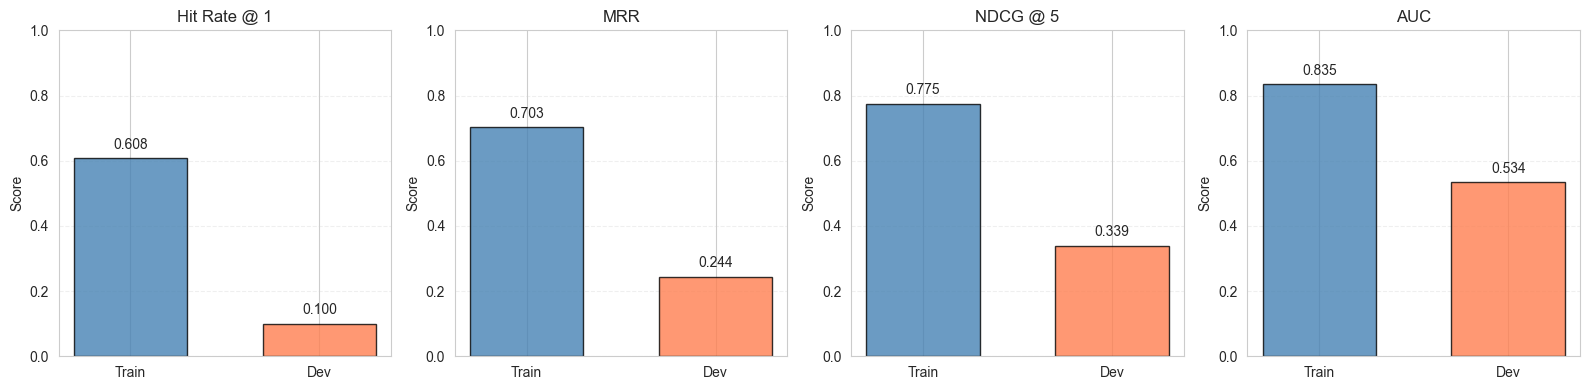

In [15]:
# Create comparison
comparison_df = pd.DataFrame({
    'Metric': ['Hit Rate @ 1', 'MRR', 'NDCG @ 5', 'AUC', 'Coverage'],
    'Train': [train_metrics['Hit Rate @ 1'], train_metrics['MRR'], train_metrics['NDCG @ 5'], 
              train_metrics['AUC'], train_metrics['Coverage']],
    'Dev': [dev_metrics['Hit Rate @ 1'], dev_metrics['MRR'], dev_metrics['NDCG @ 5'], 
            dev_metrics['AUC'], dev_metrics['Coverage']]
})
comparison_df['Difference'] = comparison_df['Train'] - comparison_df['Dev']
comparison_df['Relative Diff %'] = ((comparison_df['Train'] - comparison_df['Dev']) / comparison_df['Train'] * 100).round(2)

print("Train vs Dev Comparison:")
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
metrics_to_plot = ['Hit Rate @ 1', 'MRR', 'NDCG @ 5', 'AUC']

for i, metric in enumerate(metrics_to_plot):
    train_val = comparison_df[comparison_df['Metric'] == metric]['Train'].values[0]
    dev_val = comparison_df[comparison_df['Metric'] == metric]['Dev'].values[0]
    
    axes[i].bar(['Train', 'Dev'], [train_val, dev_val], width=0.6, 
                color=['steelblue', 'coral'], alpha=0.8, edgecolor='black')
    axes[i].set_ylabel('Score')
    axes[i].set_title(metric)
    axes[i].set_ylim([0, 1.0])
    axes[i].grid(axis='y', alpha=0.3, linestyle='--')
    axes[i].text(0, train_val + 0.02, f'{train_val:.3f}', ha='center', va='bottom')
    axes[i].text(1, dev_val + 0.02, f'{dev_val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
